<a href="https://colab.research.google.com/github/7HE-LUCKY-FISH/major_map/blob/main/notebooks/Major_Map_Hoang_Nguyen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Major Map: An AI-Powered Academic Planner and Predictor for SJSU Students

## 1. Data Loading

In [1]:
!rm -rf major_map
!git clone https://github.com/7HE-LUCKY-FISH/major_map.git

Cloning into 'major_map'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 384 (delta 63), reused 37 (delta 27), pack-reused 260 (from 1)
Receiving objects: 100% (384/384), 1.04 MiB | 10.72 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [2]:
!ls /content/

major_map  sample_data


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from pathlib import Path

In [4]:
# Path to repo in Colab
data_dir = Path("major_map/data/csv_data")

# Get all csv files
csv_files = sorted(data_dir.glob("*.csv"))

print("Found CSV files:")
for f in csv_files:
    print(" -", f.name)

# Combine all the csv files into one
# Check method number 4: https://medium.com/@stella96joshua/how-to-combine-multiple-csv-files-using-python-for-your-analysis-a88017c6ff9e
df_original = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

Found CSV files:
 - Fall-2022.csv
 - Fall-2023.csv
 - Fall-2024.csv
 - Spring-2022.csv
 - Spring-2023.csv
 - Spring-2024.csv
 - Spring-2025.csv


## 2. Data Understanding

### 2a. Basic Inspection

In [5]:
df_original.head()

,Section,Number,Mode,Title,Satifies,Unit,Type,Days,Times,Instructor,Location,Dates,Seats,Year,Semester
0,BIOL 10 (Section 01),40529,In Person,The Living World,GE: B2,3,LEC,TR,09:00AM-10:15AM,Allison Harness,SCI164,08/19/22-12/06/22,59,2022,Fall
1,BIOL 10 (Section 03),40060,In Person,The Living World,GE: B2,3,LEC,MW,10:30AM-11:45AM,Phillip Hawkins,SCI164,08/19/22-12/06/22,42,2022,Fall
2,BIOL 10 (Section 04),47603,Fully Online,The Living World,GE: B2,3,LEC,TBA,TBA,Phillip Hawkins,ONLINE,08/19/22-12/06/22,6,2022,Fall
3,BIOL 10 (Section 99),41828,Fully Online,The Living World,GE: B2,3,LEC,TBA,TBA,Mary Poffenroth,ONLINE,08/19/22-12/06/22,1,2022,Fall
4,CHEM 1A (Section 01),40081,In Person,General Chemistry,GE: B1+B3,5,LEC,MWF,09:30AM-10:20AM,Resa Kelly,SCI142,08/19/22-12/06/22,0,2022,Fall


In [6]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007 entries, 0 to 4006
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Section     4007 non-null   object
 1   Number      4007 non-null   int64 
 2   Mode        4007 non-null   object
 3   Title       4007 non-null   object
 4   Satifies    1615 non-null   object
 5   Unit        4007 non-null   int64 
 6   Type        4007 non-null   object
 7   Days        4007 non-null   object
 8   Times       4007 non-null   object
 9   Instructor  4007 non-null   object
 10  Location    3945 non-null   object
 11  Dates       4007 non-null   object
 12  Seats       4007 non-null   int64 
 13  Year        4007 non-null   int64 
 14  Semester    4007 non-null   object
dtypes: int64(4), object(11)
memory usage: 469.7+ KB


In [7]:
df_original['Year'].value_counts()

,count
Year,
2024,1191
2022,1127
2023,1115
2025,574


In [8]:
df_original['Semester'].value_counts()

,count
Semester,
Spring,2160
Fall,1847


In [9]:
df_original['Instructor'].nunique()

646

In [10]:
df_original['Section'].nunique()

980

### 2b. Check Missing / Special Values

In [11]:
df_original['Times'].value_counts().head(10)

,count
Times,
10:30AM-11:45AM,371
12:00PM-01:15PM,366
09:00AM-10:15AM,316
01:30PM-02:45PM,300
03:00PM-04:15PM,263
04:30PM-05:45PM,185
06:00PM-08:45PM,138
TBA,102
09:00AM-11:45AM,102


In [12]:
df_original['Days'].value_counts().head(10)

,count
Days,
MW,1120
TR,989
F,400
T,343
W,310
R,289
M,229
MTWR,113
TBA,102


In [13]:
print(df_original['Instructor'].value_counts())
print('\n-----------------------------\n')
print(df_original['Section'].value_counts())
print('\n-----------------------------\n')
print(df_original['Semester'].value_counts())

Instructor
Richard Low                                 53
Padmavati Tanniru                           52
Alla Petrosyan                              51
Olga Kovaleva                               48
Medha Bodas                                 47
                                            ..
Neomi Millan                                 1
Peter Beyersdorf / Kenneth Wharton           1
Ehsan Khatami                                1
Nargis Adham / Azadeh Shahid Faylienejad     1
Resa Kelly                                   1
Name: count, Length: 646, dtype: int64

-----------------------------

Section
ENGR 100W (Section 16)    14
ENGR 100W (Section 14)    14
ENGR 100W (Section 06)    14
ENGR 100W (Section 18)    11
ENGR 100W (Section 12)    10
                          ..
CMPE 165 (Section 80)      1
CS 100W (Section 84)       1
CS 146 (Section 81)        1
CS 146 (Section 82)        1
CS 147 (Section 81)        1
Name: count, Length: 980, dtype: int64

-----------------------------

Sem

## 3. Data Preprocessing

In this section we will go through each features and analyze what is the best way to preprocess the data so they can be useful to use for the machine leanring model.

In [14]:
df_preprocess = df_original.copy()
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007 entries, 0 to 4006
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Section     4007 non-null   object
 1   Number      4007 non-null   int64 
 2   Mode        4007 non-null   object
 3   Title       4007 non-null   object
 4   Satifies    1615 non-null   object
 5   Unit        4007 non-null   int64 
 6   Type        4007 non-null   object
 7   Days        4007 non-null   object
 8   Times       4007 non-null   object
 9   Instructor  4007 non-null   object
 10  Location    3945 non-null   object
 11  Dates       4007 non-null   object
 12  Seats       4007 non-null   int64 
 13  Year        4007 non-null   int64 
 14  Semester    4007 non-null   object
dtypes: int64(4), object(11)
memory usage: 469.7+ KB


### 3a. "Section" Feature

Ex: BIOL 10 (Section 01)
* Just in case, convert every value in "Section" to a string type. If something was not a string (like a number or a missing value NaN), it becomes a string (NaN --> "nan").

* Removes any leading and trailing whitespaces from each string. This is so we can split "Section" into "Dept" and "CourseNumber", or just "Course".

In [15]:
df_preprocess['Section'] = df_preprocess['Section'].astype(str).str.strip()
print("Missing Section:", df_preprocess['Section'].isna().sum())
print(df_preprocess['Section'].head())

Missing Section: 0
0    BIOL 10 (Section 01)
1    BIOL 10 (Section 03)
2    BIOL 10 (Section 04)
3    BIOL 10 (Section 99)
4    CHEM 1A (Section 01)
Name: Section, dtype: object


### 3b. "Number" Feature

Ex: 40529
* Preprocessing "Number" by ensure it's integer, and have no missing.

* "Number" feature might not be even use because this feature is not really meaningful or important.

In [16]:
df_preprocess['Number'] = df_preprocess['Number'].astype(int)
print("Missing Number:", df_preprocess['Number'].isna().sum())
print(df_preprocess['Number'].head())


Missing Number: 0
0    40529
1    40060
2    47603
3    41828
4    40081
Name: Number, dtype: int64


### 3c. "Mode" Feature

Ex: "In Person", "Fully Online", "Hybird"

* There are only 3 unique possible values for mode. We will one-hot encoding it later.

In [17]:
print("Unique Mode values:", df_preprocess['Mode'].unique())

Unique Mode values: ['In Person' 'Fully Online' 'Hybrid']


### 3d. "Title" Feature

Ex: "In Person", "Fully Online", "Hybird"

* Also not really important feature, but just clean it just in case.

In [18]:
df_preprocess['Title'] = df_preprocess['Title'].astype(str).str.strip()
print("Missing Title:", df_preprocess['Title'].isna().sum())
print(df_preprocess['Title'].head())

Missing Title: 0
0     The Living World
1     The Living World
2     The Living World
3     The Living World
4    General Chemistry
Name: Title, dtype: object


### 3e. "Satifies" Feature

* Can be use to track if it satifies for GE area or not. Fill missing (NaN) which MajorOnly.

In [19]:
print("Unique Satifies values:", df_preprocess['Satifies'].unique())
df_preprocess['Satifies'] = df_preprocess['Satifies'].fillna('MajorOnly')
print('------------------------------------------------------------')
print("Missing Satifies:", df_preprocess['Satifies'].isna().sum())

Unique Satifies values: ['GE: B2' 'GE: B1+B3' nan 'GE: S' 'GE: V' 'GE: WID' 'GE: A2' 'GE: C2'
 'GE: E' 'GE: WID+R' 'GE: B4' 'GE: 5B' 'GE: 5A+5C' 'GE: 4' 'GE: 3'
 'GE: 1A' 'GE: 3B' 'GE: WID+3' 'GE: 2']
------------------------------------------------------------
Missing Satifies: 0


### 3f. "Unit" Feature

* The unit can tell us about the hours and type of the course/section.

In [20]:
print(df_preprocess['Unit'].value_counts().sort_index())

Unit
0     905
1     234
2      60
3    2405
4     384
5      19
Name: count, dtype: int64


### 3g. "Type" Feature

* The types are LEC, SEM and LAB. Will do one hot encoding later.

In [21]:
print("Unique Type values:", df_preprocess['Type'].unique())

Unique Type values: ['LEC' 'SEM' 'LAB']


### 3h. "Days" Feature

* Give us the day patterns. TBA is a special flag. TBA is usually online and asyn classes.

In [22]:
print("Missing Days:", df_preprocess['Days'].isna().sum())
print("Unique Days values:", df_preprocess['Days'].unique())
print(df_preprocess['Days'].value_counts().sort_index())

Missing Days: 0
Unique Days values: ['TR' 'MW' 'TBA' 'MWF' 'F' 'T' 'W' 'R' 'M' 'S' 'MTWR']
Days
F        400
M        229
MTWR     113
MW      1120
MWF       86
R        289
S         26
T        343
TBA      102
TR       989
W        310
Name: count, dtype: int64


### 3i. "Times" Feature

* Give the time range (start time and end time) of a section

In [23]:
print("Missing Times:", df_preprocess['Times'].isna().sum())
print(df_preprocess['Times'].value_counts())

Missing Times: 0
Times
10:30AM-11:45AM    371
12:00PM-01:15PM    366
09:00AM-10:15AM    316
01:30PM-02:45PM    300
03:00PM-04:15PM    263
                  ... 
01:30PM-02:24PM      1
03:00PM-03:45PM      1
12:00AM-01:15AM      1
06:00PM-08:20PM      1
08:00AM-09:15AM      1
Name: count, Length: 114, dtype: int64


### 3j. "Instructor" Feature

* Give us the professor name

In [24]:
print("Missing Instructor:", df_preprocess['Instructor'].isna().sum())
print("Number of unique instructors:", df_preprocess['Instructor'].nunique())
print(df_preprocess['Instructor'].unique)

Missing Instructor: 0
Number of unique instructors: 646
<bound method Series.unique of 0                 Allison Harness
1                 Phillip Hawkins
2                 Phillip Hawkins
3                 Mary Poffenroth
4                      Resa Kelly
                  ...            
4002    Azadeh Shahid Faylienejad
4003      Vakini Santhanakrishnan
4004               Ramen Bahuguna
4005                 Nargis Adham
4006               Ramen Bahuguna
Name: Instructor, Length: 4007, dtype: object>


### 3k. "Location" Feature

* Give us the room the lecutre is held in. Online class location is lablelled as "Online"

In [25]:
print("Missing Location before fill:", df_preprocess['Location'].isna().sum())
df_preprocess['Location'] = df_preprocess['Location'].fillna('Unknown')
print("Missing Location after fill:", df_preprocess['Location'].isna().sum())
print('---------------------------------------------------------------')
print(df_preprocess['Location'].value_counts())
print('---------------------------------------------------------------')
print(df_preprocess['Location'].unique())

Missing Location before fill: 62
Missing Location after fill: 0
---------------------------------------------------------------
Location
ONLINE    366
MH424     143
MH224     105
MH323     101
ENG392     97
         ... 
BBC203      1
DMH161      1
BBC126      1
BBC107      1
ENG336      1
Name: count, Length: 195, dtype: int64
---------------------------------------------------------------
['SCI164' 'ONLINE' 'SCI142' 'MD101' 'DH412' 'DH506' 'DH507' 'ENG325'
 'ENG405' 'ENG337' 'ENG489' 'ENG343' 'ENG341' 'ENG286' 'ENG301' 'ENG331'
 'BBC003' 'ENG288' 'ENG206' 'CL222' 'DMH234' 'MH323' 'MH424' 'MH523'
 'MH222' 'MH223' 'SCI311' 'WSQ109' 'BBC202' 'MH225' 'MH422' 'MH233'
 'CL243' 'SCI258' 'DH450' 'DH351' 'BBC004' 'Unknown' 'ENG189' 'ENG258'
 'ENG290' 'ENG305' 'ENG345' 'ENG307' 'ENG238' 'ENG317' 'ENG319' 'ENG321'
 'ENG244' 'ENG289' 'ENG291' 'ENG376' 'BBC124' 'SH411' 'BBC121' 'BBC128'
 'BBC122' 'SH348' 'DMH354' 'BBC123' 'BBC221' 'CL316' 'BBC130' 'CL225B'
 'SH444' 'CL225A' 'BBC225' 'DMH347' 'SH4

### 3l. "Dates" Feature

* Not really important, we already have Year and Semester

In [26]:
print("Missing Dates:", df_preprocess['Dates'].isna().sum())
print(df_preprocess['Dates'].value_counts())

Missing Dates: 0
Dates
08/21/24-12/09/24    631
08/21/23-12/06/23    626
08/19/22-12/06/22    590
01/23/25-05/12/25    574
01/24/24-05/13/24    560
01/26/22-05/16/22    537
01/25/23-05/15/23    489
Name: count, dtype: int64


### 3m. "Seats" Feature

* Number of seats left for a section. Not really useful, will drop this feature.

In [27]:
df_preprocess['Seats'] = df_preprocess['Seats'].astype(int)
print("Missing Seats:", df_preprocess['Seats'].isna().sum())
print(df_preprocess['Seats'].describe())

Missing Seats: 0
count    4007.000000
mean        3.279760
std         9.260627
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max       181.000000
Name: Seats, dtype: float64


### 3n. "Year" Feature

* Calendar Year: should be only 2022, 2023, 2024 and 2025

In [28]:
print("Missing Year:", df_preprocess['Year'].isna().sum())
print("Years:", df_preprocess['Year'].unique())

Missing Year: 0
Years: [2022 2023 2024 2025]


### 3o. "Semester" Feature

* Term name: We only focus on Fall and Spring (no Winter or Summer)

In [29]:
print("Missing Semester:", df_preprocess['Semester'].isna().sum())
print("Semesters:", df_preprocess['Semester'].unique())

Missing Semester: 0
Semesters: ['Fall' 'Spring']


In [30]:
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007 entries, 0 to 4006
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Section     4007 non-null   object
 1   Number      4007 non-null   int64 
 2   Mode        4007 non-null   object
 3   Title       4007 non-null   object
 4   Satifies    4007 non-null   object
 5   Unit        4007 non-null   int64 
 6   Type        4007 non-null   object
 7   Days        4007 non-null   object
 8   Times       4007 non-null   object
 9   Instructor  4007 non-null   object
 10  Location    4007 non-null   object
 11  Dates       4007 non-null   object
 12  Seats       4007 non-null   int64 
 13  Year        4007 non-null   int64 
 14  Semester    4007 non-null   object
dtypes: int64(4), object(11)
memory usage: 469.7+ KB


## 4. Data Engineering

In [31]:
# Make a copy for data engineering
df_engineer = df_preprocess.copy()

Originally, we have a total of 15 features:
1. Section          (original)
2. Number           (original, not used as feature)
3. Mode             (original, categorical feature)
4. Title            (original, usually not used as feature in v1)
5. Satifies         (original, optional categorical feature)
6. Unit             (original, numeric feature)
7. Type             (original, categorical feature)
8. Days             (original, used to build slot, not as input feature)
9. Times            (original, used to build StartMinutes/slot)
10. Instructor      (original, used to create instructor_id target)
11. Location        (original)
12. Dates           (original, not used as feature)
13. Seats           (original)
14. Year            (original, numeric feature)
15. Semester        (original, categorical feature)

New Features we will get from data engineering:
1. Dept            (engineered from Section)
2. CourseNumber    (engineered from Section)
3. CourseCode     (engineered from Dept + CourseNumber, optional)
4. HasGE           (engineered from Satifies, 0/1 flag, optional)
5. StartMinutes    (engineered from Times)
6. EndMinutes      (engineered from Times)
7. DurationMinutes (engineered from End-Start)
7. Slot            (engineered from Days + StartMinutes, e.g. "MWF_540")
8. instructor_id   (engineered target from Instructor)
9. slot_id         (engineered target from slot)
10. Building        (engineered from Location, e.g. "SCI", "MD", "ONLINE")
12. Term            (engineered from Year + Semester, e.g. "2022_Fall")
13. SemesterIndex   (engineered from term, 0,1,2,... in time order)

---






### 4a. Section → Dept, CourseNumber, and CourseCode

In [32]:
section = df_engineer['Section'].str.extract(r'^(\w+)\s+([^\s]+)')

df_engineer['Dept'] = section[0]
df_engineer['CourseNumber'] = section[1]
df_engineer['CourseCode'] = df_engineer['Dept'].astype(str) + ' ' + df_engineer['CourseNumber'].astype(str)
df_engineer[['Section', 'Dept', 'CourseNumber', 'CourseCode']].head()

,Section,Dept,CourseNumber,CourseCode
0,BIOL 10 (Section 01),BIOL,10,BIOL 10
1,BIOL 10 (Section 03),BIOL,10,BIOL 10
2,BIOL 10 (Section 04),BIOL,10,BIOL 10
3,BIOL 10 (Section 99),BIOL,10,BIOL 10
4,CHEM 1A (Section 01),CHEM,1A,CHEM 1A


### 4b. Times → StartMinutes and EndMinutes

* Minutes after midnight (00:00 am)

In [33]:
def parse_time_range(s):
  if s == "TBA" or "-" not in s:
    return -1, -1, -1

  # s looks like "09:00AM-10:15AM"
  # split the start and end with '-'
  start_str, end_str = s.split('-')

  # parse each part as time
  # format='%I:%M%p'
  # %I = hour in 12-hour clock (01-12)
  # %M = minutes (00-59)
  # %p = AM/PM
  start_dt = pd.to_datetime(start_str, format='%I:%M%p')
  end_dt   = pd.to_datetime(end_str,   format='%I:%M%p')

  # convert to "minutes since midnight"
  start_min = start_dt.hour * 60 + start_dt.minute
  end_min = end_dt.hour * 60 + end_dt.minute

  # section duration
  duration_min = end_min - start_min

  return start_min, end_min, duration_min

# Apply to df_model['Times'] and create three new columns
df_engineer[['StartMinutes', 'EndMinutes', 'DurationMinutes']] = df_engineer['Times'].apply(
    lambda s: pd.Series(parse_time_range(s))
)

df_engineer[['Times', 'StartMinutes', 'EndMinutes', 'DurationMinutes']].head()


,Times,StartMinutes,EndMinutes,DurationMinutes
0,09:00AM-10:15AM,540,615,75
1,10:30AM-11:45AM,630,705,75
2,TBA,-1,-1,-1
3,TBA,-1,-1,-1
4,09:30AM-10:20AM,570,620,50


### 4c. Days + StartMinutes → Slot

* This show use the day and start minute. This feature is important for schedule planning later.

* We will later turn them into Slot_ID

In [34]:
def make_slot(row):
    days = str(row['Days']).strip()
    if (row['StartMinutes'] == -1):
        return days + '_TBA'
    else:
        return days + '_' + str(int(row['StartMinutes']))

df_engineer['Slot'] = df_engineer.apply(make_slot, axis=1)
df_engineer[['Days', 'Times', 'StartMinutes', 'Slot']].head()

,Days,Times,StartMinutes,Slot
0,TR,09:00AM-10:15AM,540,TR_540
1,MW,10:30AM-11:45AM,630,MW_630
2,TBA,TBA,-1,TBA_TBA
3,TBA,TBA,-1,TBA_TBA
4,MWF,09:30AM-10:20AM,570,MWF_570


### 4d. Satifies → HasGE

* Pretty straightforward. Class that have satifies mean it is in the major requirements. This feature can be good to create roadmaps as well as schedules later.


In [35]:
print(df_engineer['Satifies'].unique())
print('---------------------------------------------')
# 1 if it's a GE area ("GE: ..."), 0 if MajorOnly or anything else
df_engineer['HasGE'] = df_engineer['Satifies'].astype(str).str.startswith('GE:').astype(int)
print('---------------------------------------------')
print(df_engineer[['Satifies', 'HasGE']].head())
print('---------------------------------------------')
print(df_engineer['HasGE'].value_counts())

['GE: B2' 'GE: B1+B3' 'MajorOnly' 'GE: S' 'GE: V' 'GE: WID' 'GE: A2'
 'GE: C2' 'GE: E' 'GE: WID+R' 'GE: B4' 'GE: 5B' 'GE: 5A+5C' 'GE: 4'
 'GE: 3' 'GE: 1A' 'GE: 3B' 'GE: WID+3' 'GE: 2']
---------------------------------------------
---------------------------------------------
    Satifies  HasGE
0     GE: B2      1
1     GE: B2      1
2     GE: B2      1
3     GE: B2      1
4  GE: B1+B3      1
---------------------------------------------
HasGE
0    2392
1    1615
Name: count, dtype: int64


### 4e. Location → Building

* Ex: SCI164 into SCI, and Online stays Online
* Note: MD is Morris Dailey Auditorium, the SJSU website had changed the name into Town Hall


In [36]:
def get_building(location):
  location = str(location).strip()
  if location in ['ONLINE', 'Unknown']:
    return location

  prefix = ''
  for ch in location:
    if ch.isalpha():
      prefix += ch
    else:
      break
  return prefix if prefix else 'Unknown'

df_engineer['Building'] = df_engineer['Location'].apply(get_building)
print(df_engineer['Building'].value_counts())

Building
ENG        1159
MH          662
DH          516
ONLINE      366
SCI         314
BBC         281
SH          188
CL          176
WSQ         138
DMH          90
Unknown      62
MD           24
ISB          15
YUH           9
HGH           2
CCB           2
IS            2
DBH           1
Name: count, dtype: int64


### 4e. Year + Semester → Term

In [37]:
df_engineer['Term'] = df_engineer['Year'].astype(str) + '_' + df_engineer['Semester'].astype(str)
df_engineer[['Year', 'Semester', 'Term']].head()

,Year,Semester,Term
0,2022,Fall,2022_Fall
1,2022,Fall,2022_Fall
2,2022,Fall,2022_Fall
3,2022,Fall,2022_Fall
4,2022,Fall,2022_Fall


### 4f. Semester → SemesterIndex

* Sort the unique terms and assing 0, 1, 2,... in time order

In [38]:
sem_order = {'Spring': 0, 'Fall': 1}

# Unique (Year, Semester) combos
term_df = (
    df_engineer[['Year', 'Semester']]
    .drop_duplicates()
    .copy()
)


# Sort by Year, then Spring/Fall
term_df['sem_order'] = term_df['Semester'].map(sem_order)
term_df = term_df.sort_values(['Year', 'sem_order']).reset_index(drop=True)

# Assign 0,1,2,... as SemesterIndex
term_df['SemesterIndex'] = term_df.index

print(term_df)

# Merge into df_engineer
df_engineer = df_engineer.merge(
    term_df[['Year', 'Semester', 'SemesterIndex']],
    on=['Year', 'Semester'],
    how='left'
)

print(
    df_engineer[['Year', 'Semester', 'SemesterIndex']]
    .drop_duplicates()
    .sort_values('SemesterIndex')
)


   Year Semester  sem_order  SemesterIndex
0  2022   Spring          0              0
1  2022     Fall          1              1
2  2023   Spring          0              2
3  2023     Fall          1              3
4  2024   Spring          0              4
5  2024     Fall          1              5
6  2025   Spring          0              6
      Year Semester  SemesterIndex
1847  2022   Spring              0
0     2022     Fall              1
2384  2023   Spring              2
590   2023     Fall              3
2873  2024   Spring              4
1216  2024     Fall              5
3433  2025   Spring              6


### 4g. Label Encoding Targets: Instructor, Slot and CourseCode
* Encode each unique instructor, slot, and course code as an integer ID using `LabelEncoder`.

In [39]:
instr_le = LabelEncoder()
df_engineer['Instructor_ID'] = instr_le.fit_transform(df_engineer['Instructor'])

print("Number of unique instructors:", df_engineer['Instructor_ID'].nunique())
df_engineer[['Instructor', 'Instructor_ID']].head()

Number of unique instructors: 646


,Instructor,Instructor_ID
0,Allison Harness,35
1,Phillip Hawkins,439
2,Phillip Hawkins,439
3,Mary Poffenroth,363
4,Resa Kelly,471


In [40]:
# LabelEncode Slot → slot_id
slot_le = LabelEncoder()
df_engineer['Slot_ID'] = slot_le.fit_transform(df_engineer['Slot'])

print("Number of unique slots:", df_engineer['Slot_ID'].nunique())
df_engineer[['Slot', 'Slot_ID']].head()

Number of unique slots: 142


,Slot,Slot_ID
0,TR_540,98
1,MW_630,45
2,TBA_TBA,88
3,TBA_TBA,88
4,MWF_570,29


In [41]:
course_le = LabelEncoder()
df_engineer['CourseCode_ID'] = course_le.fit_transform(df_engineer['CourseCode'])

print("Number of unique course codes:", df_engineer['CourseCode_ID'].nunique())
df_engineer[['CourseCode', 'CourseCode_ID']].head()

Number of unique course codes: 92


,CourseCode,CourseCode_ID
0,BIOL 10,0
1,BIOL 10,0
2,BIOL 10,0
3,BIOL 10,0
4,CHEM 1A,1


In [42]:
print(df_engineer.info())
print("-------------------------------------------")
df_engineer.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007 entries, 0 to 4006
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Section          4007 non-null   object
 1   Number           4007 non-null   int64 
 2   Mode             4007 non-null   object
 3   Title            4007 non-null   object
 4   Satifies         4007 non-null   object
 5   Unit             4007 non-null   int64 
 6   Type             4007 non-null   object
 7   Days             4007 non-null   object
 8   Times            4007 non-null   object
 9   Instructor       4007 non-null   object
 10  Location         4007 non-null   object
 11  Dates            4007 non-null   object
 12  Seats            4007 non-null   int64 
 13  Year             4007 non-null   int64 
 14  Semester         4007 non-null   object
 15  Dept             4007 non-null   object
 16  CourseNumber     4007 non-null   object
 17  CourseCode       4007 non-null   

,Section,Number,Mode,Title,Satifies,Unit,Type,Days,Times,Instructor,...,EndMinutes,DurationMinutes,Slot,HasGE,Building,Term,SemesterIndex,Instructor_ID,Slot_ID,CourseCode_ID
0,BIOL 10 (Section 01),40529,In Person,The Living World,GE: B2,3,LEC,TR,09:00AM-10:15AM,Allison Harness,...,615,75,TR_540,1,SCI,2022_Fall,1,35,98,0
1,BIOL 10 (Section 03),40060,In Person,The Living World,GE: B2,3,LEC,MW,10:30AM-11:45AM,Phillip Hawkins,...,705,75,MW_630,1,SCI,2022_Fall,1,439,45,0
2,BIOL 10 (Section 04),47603,Fully Online,The Living World,GE: B2,3,LEC,TBA,TBA,Phillip Hawkins,...,-1,-1,TBA_TBA,1,ONLINE,2022_Fall,1,439,88,0
3,BIOL 10 (Section 99),41828,Fully Online,The Living World,GE: B2,3,LEC,TBA,TBA,Mary Poffenroth,...,-1,-1,TBA_TBA,1,ONLINE,2022_Fall,1,363,88,0
4,CHEM 1A (Section 01),40081,In Person,General Chemistry,GE: B1+B3,5,LEC,MWF,09:30AM-10:20AM,Resa Kelly,...,620,50,MWF_570,1,SCI,2022_Fall,1,471,29,1


# Targets & Scenarios

* Scenarios A: Course → Professor
  * “Who is likely to teach this course?”
  * Predict Instructor_ID
  * Input: course info (CourseCode, Dept, Unit, Mode, Type, Semester, etc)
  * Target: Instructor_ID

* Scenarios B: Course → Slot
  * When (what slot) is this course likely to be scheduled?”
  * Predict Slot_ID
  * Input: similar features as A
  * Target: Slot_ID

* Scenarios C: Professor → Course
  * What course is this professor likely to teach?
  * Predict CourseCode_ID
  * Input: Professor + Term (Instructor_ID, SemesterIndex, etc)
  * Target: CourseCode_ID

# Modeling Framework

After some research, here are the machine learning models/algorithms we want to test (based on this article: https://gursev-pirge.medium.com/performance-comparison-of-multi-class-classification-algorithms-606e8ba4e0ee)

* Decision Tree
* Random Forest
* XGBoost
* SVM
* NaiveBayes

* ARIMA/ETS (time series)
* Neural Networks

## Create DataFrame for Model

In [43]:
df_model = df_engineer.copy()
df_model.columns

Index(['Section', 'Number', 'Mode', 'Title', 'Satifies', 'Unit', 'Type',
       'Days', 'Times', 'Instructor', 'Location', 'Dates', 'Seats', 'Year',
       'Semester', 'Dept', 'CourseNumber', 'CourseCode', 'StartMinutes',
       'EndMinutes', 'DurationMinutes', 'Slot', 'HasGE', 'Building', 'Term',
       'SemesterIndex', 'Instructor_ID', 'Slot_ID', 'CourseCode_ID'],
      dtype='object')

## Split Data by Semester Order

In [44]:
all_terms = sorted(df_model['SemesterIndex'].unique())
print("All SemesterIndex values:", all_terms)

# Chose the 2 most recent terms as test set (Fall 2024 and Spring 2025)
test_terms = all_terms[-2:]   # last two terms
print("Test terms (SemesterIndex):", test_terms)

# Split into Train and Test set
train_mask = ~df_model['SemesterIndex'].isin(test_terms)
test_mask = df_model['SemesterIndex'].isin(test_terms)

All SemesterIndex values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Test terms (SemesterIndex): [np.int64(5), np.int64(6)]


## Run Model Function

This function will be reuse to run all models

In [45]:
from sklearn.metrics import accuracy_score

def run_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc  = accuracy_score(y_test, y_pred_test)

    print(f"Train accuracy: {train_acc:.3f}")
    print(f"Test  accuracy: {test_acc:.3f}")

    return {
        "model": name,
        "train_acc": train_acc,
        "test_acc": test_acc
    }

## Feature Selection for Scenarios A/B and C

 0   Section:       Dropped (Reason: used to get Dept and CourseNumber)  

 1   Number:        Dropped (Reason: not useful)

 2   Mode:          Kept    (Reason: useuful to check if in-person or online)

 3   Title:         Dropped (Reason: not useful)    

 4   Satifies:      Dropped (Reason: used to get HasGE)

 5   Unit:          Kept    (Reason: useuful to check the type of class)

 6   Type:          Kept    (Reason: useuful to check lecture/seminar/lab)

 7   Days:          Dropped (Reason: used to get Slot)

 8   Times:         Dropped (Reason: used to get start and end minutes)

 9   Instructor:    Dropped (Reason: used to get Instructor_ID)    

 10  Location:      Dropped (Reason: used to get the building)  

 11  Dates:          Dropped (Reason: not useful)

 12  Seats:          Dropped (Reason: not useful)

 13  Year:           Kept    (Reason: useful to tell us which year)

 14  Semester:       Kept    (Reason: useful to tell us which Spring/Fall)

 15  Dept:           Kept    (Reason: engineered from section)

 16  CourseNumber:   Optional (Reason: engineered from section)

 17  CourseCode:     Kept    (Reason: engineered from Dept and CourseNumber)

 18  StartMinutes:   Optional    (Reason: engineered from Times)

 19  EndMinutes:     Optional     (Reason: engineered from Times)

 20  DurationMinutes: Kept  (Reason: engineered from end - start minutes)

 21  Slot:           Dropped (Reason: used to get Slot_ID)

 22  HasGE:          Kept    (Reason: engineered from Satifies)

 23  Building:       Kept    (Reason: engineered from Location)

 24  Term:           Optional(Reason: engineered from Year + Semester)

 25  SemesterIndex:  Kept    (Reason: important to calculate the time order)

 26  Instructor_ID:  Target

 27  Slot_ID:        Target

 28  CourseCode_ID:  Target

In [46]:
# Categorical features (will be one-hot encoded)
cat_cols_AB = [
    'Dept',
    'CourseCode',
    'Mode',
    'Type',
    'Semester',
    'Building',
  ]

# Numeric features (keep as-is)
num_cols_AB = [
    'Unit',
    'Year',
    'SemesterIndex',
    'DurationMinutes',
    'HasGE'
]

feature_cols_AB = cat_cols_AB + num_cols_AB
print("Feature columns:", feature_cols_AB)

Feature columns: ['Dept', 'CourseCode', 'Mode', 'Type', 'Semester', 'Building', 'Unit', 'Year', 'SemesterIndex', 'DurationMinutes', 'HasGE']


In [47]:
# Categorical + numeric features for professor-based model (Scenario C)
cat_cols_C = [
    'Instructor',
    'Mode',
    'Type',
    'Semester',
    'Building',
]

num_cols_C = [
    'Year',
    'SemesterIndex'
]

feature_cols_C = cat_cols_C + num_cols_C
print("Feature columns:", feature_cols_C)

Feature columns: ['Instructor', 'Mode', 'Type', 'Semester', 'Building', 'Year', 'SemesterIndex']


## Create Train and Test Set

In [48]:
X_A = df_model[feature_cols_AB].copy()
y_A = df_model['Instructor_ID'].copy()

# One-hot encode categoricals
X_A_enc = pd.get_dummies(X_A, columns=cat_cols_AB, drop_first=False)

X_train_A = X_A_enc[train_mask]
y_train_A = y_A[train_mask]

X_test_A  = X_A_enc[test_mask]
y_test_A  = y_A[test_mask]

print("Scenario A shapes:", X_train_A.shape, X_test_A.shape)

Scenario A shapes: (2802, 136) (1205, 136)


In [49]:
X_B = df_model[feature_cols_AB].copy()
y_B = df_model['Slot_ID'].copy()

# One-hot encode categoricals
X_B_enc = pd.get_dummies(X_B, columns=cat_cols_AB, drop_first=False)

X_train_B = X_B_enc[train_mask]
y_train_B = y_B[train_mask]

X_test_B = X_B_enc[test_mask]
y_test_B = y_B[test_mask]

print("Scenario B shapes:", X_train_B.shape, X_test_B.shape)

Scenario B shapes: (2802, 136) (1205, 136)


In [50]:
X_C = df_model[feature_cols_C].copy()
y_C = df_model['CourseCode_ID'].copy()

# One-hot encode categoricals
X_C_enc = pd.get_dummies(X_C, columns=cat_cols_C, drop_first=False)

X_train_C = X_C_enc[train_mask]
y_train_C = y_C[train_mask]

X_test_C  = X_C_enc[test_mask]
y_test_C  = y_C[test_mask]

print("Scenario C shapes:", X_train_C.shape, X_test_C.shape)

Scenario C shapes: (2802, 674) (1205, 674)


# Decision Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier

In [52]:
dt_instr = DecisionTreeClassifier(
    max_depth=15,      # limit depth to avoid insane overfitting
    min_samples_split=10,
    random_state=42
)

dt_A_results = run_model(
    "DecisionTree – Scenario A (Instructor)",
    dt_instr,
    X_train_A, y_train_A,
    X_test_A,  y_test_A
)



=== DecisionTree – Scenario A (Instructor) ===
Train accuracy: 0.260
Test  accuracy: 0.135


In [53]:
dt_slot = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=10,
    random_state=42
)

dt_B_results = run_model(
    "DecisionTree – Scenario B (Slot)",
    dt_slot,
    X_train_B, y_train_B,
    X_test_B,  y_test_B
)



=== DecisionTree – Scenario B (Slot) ===
Train accuracy: 0.261
Test  accuracy: 0.198


In [54]:
dt_course = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=10,
    random_state=42
)

dt_C_results = run_model(
    "DecisionTree – Scenario C (Course)",
    dt_course,
    X_train_C, y_train_C,
    X_test_C,  y_test_C
)



=== DecisionTree – Scenario C (Course) ===
Train accuracy: 0.552
Test  accuracy: 0.408


# Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
# Random Forest for Instructor
rf_instr = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf_A_results = run_model("RandomForest – Scenario A (Instructor)",
                         rf_instr, X_train_A, y_train_A, X_test_A, y_test_A)


=== RandomForest – Scenario A (Instructor) ===
Train accuracy: 0.521
Test  accuracy: 0.239


In [57]:
rf_slot = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf_B_results = run_model("RandomForest – Scenario B (Slot)",
                         rf_slot, X_train_B, y_train_B, X_test_B, y_test_B)


=== RandomForest – Scenario B (Slot) ===
Train accuracy: 0.401
Test  accuracy: 0.227


In [58]:
rf_course = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf_C_results = run_model("RandomForest – Scenario C (Course)",
                         rf_course, X_train_C, y_train_C, X_test_C, y_test_C)


=== RandomForest – Scenario C (Course) ===
Train accuracy: 0.904
Test  accuracy: 0.568


# XGBoost

* Problem: XGBoost can't handle unseen class labels
* Solution: Removes the unseen rows

In [59]:
from xgboost import XGBClassifier

In [60]:
xgb_params = dict(
    objective="multi:softprob",   # use for multi-class classification, ouput probability probability distribution over classes for each sample
    n_estimators=400,             # how many trees we build, same as random forest
    max_depth = 6,                # maximum depth of each decision tree
    learning_rate= 0.05,          # smaller learning rate = each tree makes a small correction, need more trees to reach good performance
    subsample=0.8,                # randomly samples 80% of the rows, randoness reduce overfitting and improve test perofrmance (0.8 is common)
    colsample_bytree=0.8,         # for each tree, use only 80% of the features (0.8 is a common choice)
    tree_method="hist",           # use histogram-based algorithm, much more and more efficent
    eval_metric="mlogloss",       # use multi-class log loss (cross-entropy)
    random_state=42,              # same as random forest
)

In [61]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# encode labels
le = LabelEncoder()
y_train_A_enc = le.fit_transform(y_train_A)      # 0..K-1

# 2) Keep only test rows whose labels exist in train
seen_mask = y_test_A.isin(le.classes_)

# Keep only the "seen" for test input features
X_test_A_seen = X_test_A.loc[seen_mask]

# Keep only the "seen" for test ouput labels
y_test_A_seen = y_test_A.loc[seen_mask]

# Now that y_test_seen contains only isntructors that exist in training, we can encoded them
y_test_A_enc  = le.transform(y_test_A_seen)

print("Test rows kept:", seen_mask.sum(), " / dropped (unseen):", (~seen_mask).sum())

# 3) Train XGBoost multiclass
xgb_instr = XGBClassifier(**xgb_params)

xgb_A_results = run_model(
    "XGBoost – Scenario A (Instructor)",
    xgb_instr,
    X_train_A, y_train_A_enc,
    X_test_A_seen, y_test_A_enc
)


Test rows kept: 947  / dropped (unseen): 258

=== XGBoost – Scenario A (Instructor) ===
Train accuracy: 0.484
Test  accuracy: 0.283


In [62]:
# encode labels
le = LabelEncoder()
y_train_B_enc = le.fit_transform(y_train_B)      # 0..K-1

# 2) Keep only test rows whose labels exist in train
seen_mask = y_test_B.isin(le.classes_)

# Keep only the "seen" for test input features
X_test_B_seen = X_test_B.loc[seen_mask]

# Keep only the "seen" for test ouput labels
y_test_B_seen = y_test_B.loc[seen_mask]

# Now that y_test_seen contains only isntructors that exist in training, we can encoded them
y_test_B_enc  = le.transform(y_test_B_seen)

print("Test rows kept:", seen_mask.sum(), " / dropped (unseen):", (~seen_mask).sum())

# 3) Train XGBoost multiclass
xgb_slot = XGBClassifier(**xgb_params)

xgb_B_results = run_model(
    "XGBoost – Scenario B (Slot)",
    xgb_slot,
    X_train_B, y_train_B_enc,
    X_test_B_seen, y_test_B_enc
)


Test rows kept: 1203  / dropped (unseen): 2

=== XGBoost – Scenario B (Slot) ===
Train accuracy: 0.370
Test  accuracy: 0.255


In [63]:
# encode labels
le = LabelEncoder()
y_train_C_enc = le.fit_transform(y_train_C)      # 0..K-1

# 2) Keep only test rows whose labels exist in train
seen_mask = y_test_C.isin(le.classes_)

# Keep only the "seen" for test input features
X_test_C_seen = X_test_C.loc[seen_mask]

# Keep only the "seen" for test ouput labels
y_test_C_seen = y_test_C.loc[seen_mask]

# Now that y_test_seen contains only isntructors that exist in training, we can encoded them
y_test_C_enc  = le.transform(y_test_C_seen)

print("Test rows kept:", seen_mask.sum(), " / dropped (unseen):", (~seen_mask).sum())

# 3) Train XGBoost multiclass
xgb_course = XGBClassifier(**xgb_params)

xgb_C_results = run_model(
    "XGBoost – Scenario C (Course)",
    xgb_course,
    X_train_C, y_train_C_enc,
    X_test_C_seen, y_test_C_enc
)


Test rows kept: 1205  / dropped (unseen): 0

=== XGBoost – Scenario C (Course) ===
Train accuracy: 0.711
Test  accuracy: 0.520


# Naive Bayes
* Naive Bayes makes strong independence assumption so it is fast but trade-off with less accuracy

In [64]:
from sklearn.naive_bayes import GaussianNB

In [65]:
gnb_instr = GaussianNB()

naive_A_results = run_model(
    "GaussianNB – Scenario A (Instructor)",
    gnb_instr,
    X_train_A.to_numpy(),
    y_train_A,
    X_test_A.to_numpy(),
    y_test_A
)


=== GaussianNB – Scenario A (Instructor) ===
Train accuracy: 0.354
Test  accuracy: 0.189


In [66]:
gnb_slot = GaussianNB()

naive_B_results = run_model(
    "GaussianNB – Scenario B (Slot)",
    gnb_slot,
    X_train_B.to_numpy(),
    y_train_B,
    X_test_B.to_numpy(),
    y_test_B
)



=== GaussianNB – Scenario B (Slot) ===
Train accuracy: 0.186
Test  accuracy: 0.142


In [67]:
gnb_course = GaussianNB()

naive_C_results = run_model(
    "GaussianNB – Scenario C (Course)",
    gnb_course,
    X_train_C.to_numpy(),
    y_train_C,
    X_test_C.to_numpy(),
    y_test_C
)


=== GaussianNB – Scenario C (Course) ===
Train accuracy: 0.764
Test  accuracy: 0.516


# SVM

In [68]:
from sklearn.svm import LinearSVC

In [69]:
svm_instr = LinearSVC(
    max_iter=300,
    C=1.0,
    class_weight='balanced',
    random_state=42
)

svm_A_results = run_model(
    "LinearSVC – Scenario A (Instructor)",
    svm_instr,
    X_train_A,
    y_train_A,
    X_test_A,
    y_test_A
)


=== LinearSVC – Scenario A (Instructor) ===
Train accuracy: 0.377
Test  accuracy: 0.047


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [70]:
svm_slot = LinearSVC(
    max_iter=300,
    C=1.0,
    class_weight='balanced',
    random_state=42
)

svm_B_results = run_model(
    "LinearSVC – Scenario B (Slot)",
    svm_slot,
    X_train_B,
    y_train_B,
    X_test_B,
    y_test_B
)


=== LinearSVC – Scenario B (Slot) ===
Train accuracy: 0.186
Test  accuracy: 0.064


In [71]:
svm_course = LinearSVC(
    max_iter=300,
    C=1.0,
    class_weight='balanced',
    random_state=42
)

svm_C_results = run_model(
    "LinearSVC – Scenario C (Course)",
    svm_course,
    X_train_C,
    y_train_C,
    X_test_C,
    y_test_C
)


=== LinearSVC – Scenario C (Course) ===
Train accuracy: 0.761
Test  accuracy: 0.266


# Model Comparison

In [72]:
import pandas as pd

results = []

def add_result(res_dict, scenario_label):
    d = res_dict.copy()
    d["scenario"] = scenario_label
    results.append(d)

# ---- Scenario A: Course → Instructor ----
add_result(rf_A_results,    "A: Course → Instructor")
add_result(dt_A_results,    "A: Course → Instructor")
add_result(naive_A_results, "A: Course → Instructor")
add_result(svm_A_results,   "A: Course → Instructor")
add_result(xgb_A_results,   "A: Course → Instructor")

# ---- Scenario B: Course → Slot ----
add_result(rf_B_results,    "B: Course → Slot")
add_result(dt_B_results,    "B: Course → Slot")
add_result(naive_B_results, "B: Course → Slot")
add_result(svm_B_results,   "B: Course → Slot")
add_result(xgb_B_results,   "B: Course → Slot")

# ---- Scenario C: Professor → Course ----
add_result(rf_C_results,    "C: Prof → Course")
add_result(dt_C_results,    "C: Prof → Course")
add_result(naive_C_results, "C: Prof → Course")
add_result(svm_C_results,   "C: Prof → Course")
add_result(xgb_C_results,   "C: Prof → Course")

# Build DataFrame
df_results = pd.DataFrame(results)

# Reorder columns and round based on test accuracies
df_results = (
    df_results[["scenario", "model", "train_acc", "test_acc"]]
    .assign(
        train_acc=lambda d: d["train_acc"].round(3),
        test_acc=lambda d: d["test_acc"].round(3),
    )
    .sort_values(["scenario", "test_acc"], ascending=[True, False])
)



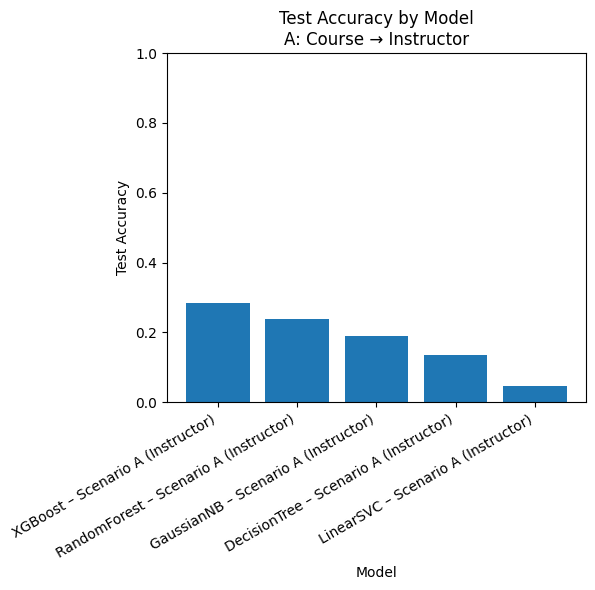

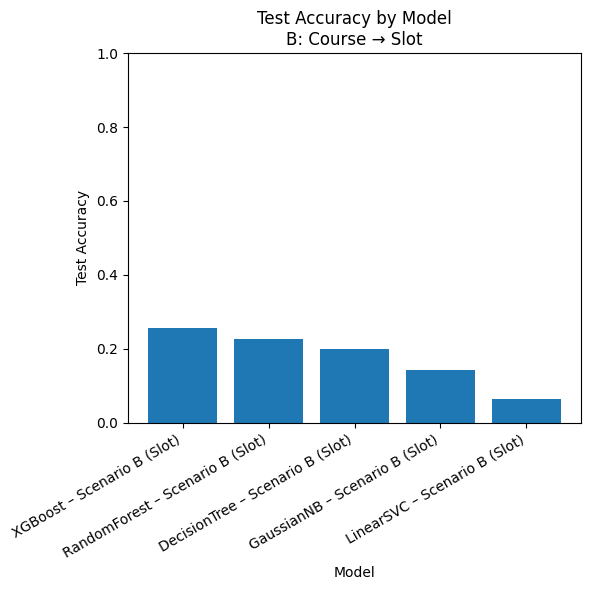

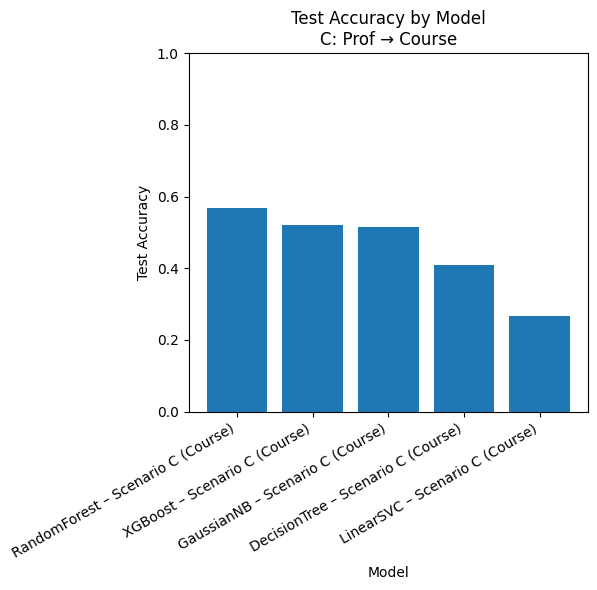

In [73]:
import matplotlib.pyplot as plt

scenarios = df_results['scenario'].unique()

for scen in scenarios:
    sub = df_results[df_results['scenario'] == scen]

    plt.figure(figsize=(6, 6))
    plt.bar(sub['model'], sub['test_acc'])
    plt.ylim(0, 1)
    plt.title(f"Test Accuracy by Model\n{scen}")
    plt.xlabel("Model")
    plt.ylabel("Test Accuracy")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()
    print()



Across all three prediction scenarios, the model parsion show a clearn pattern that tree-based enemble models perform best. Random Forest and XGBoost consistently achieve the highest test accuracy, espaecially in Scenarios C. Single Decision Tree, and Naive Bayes have lower test accuracy and linear SVM have the lowest test accuracy overall. This show that scheduling patterns are not good to be capture by simple linear or indepedence based model.

# Top-k Accuracy

* This section is to test the website behavior where we will likely provide the top 3 likely profs/slots/courses to the user for our machine learning model prediction.

In [74]:
import numpy as np

def topk_accuracy(model, X_test, y_test, k=3):
    proba = model.predict_proba(X_test)
    classes = model.classes_                    # actual label values
    # topk_idx: positions in the classes_ array
    topk_idx = np.argsort(proba, axis=1)[:, -k:]
    # map to actual labels
    topk_labels = classes[topk_idx]             # shape: (n_samples, k)

    y_true = y_test.to_numpy() if hasattr(y_test, "to_numpy") else np.array(y_test)
    correct = 0
    for i, true_label in enumerate(y_true):
        if true_label in topk_labels[i]:        # compare label to labels, not indices
            correct += 1
    return correct / len(y_true)

In [75]:
top1_A = accuracy_score(y_test_A, rf_instr.predict(X_test_A))
top3_A = topk_accuracy(rf_instr, X_test_A, y_test_A, k=3)
top5_A = topk_accuracy(rf_instr, X_test_A, y_test_A, k=5)

print("Scenario A – Random Forest (Instructor)")
print("  top-1 accuracy:", round(top1_A, 3))
print("  top-3 accuracy:", round(top3_A, 3))
print("  top-5 accuracy:", round(top5_A, 3))

Scenario A – Random Forest (Instructor)
  top-1 accuracy: 0.239
  top-3 accuracy: 0.394
  top-5 accuracy: 0.485


In [76]:
top1_B = accuracy_score(y_test_B, rf_slot.predict(X_test_B))
top3_B = topk_accuracy(rf_slot, X_test_B, y_test_B, k=3)
top5_B = topk_accuracy(rf_slot, X_test_B, y_test_B, k=5)

print("\nScenario B – Random Forest (Slot)")
print("  top-1 accuracy:", round(top1_B, 3))
print("  top-3 accuracy:", round(top3_B, 3))
print("  top-5 accuracy:", round(top5_B, 3))


Scenario B – Random Forest (Slot)
  top-1 accuracy: 0.227
  top-3 accuracy: 0.482
  top-5 accuracy: 0.65


In [77]:
top1_C = accuracy_score(y_test_C, rf_course.predict(X_test_C))
top3_C = topk_accuracy(rf_course, X_test_C, y_test_C, k=3)
top5_C = topk_accuracy(rf_course, X_test_C, y_test_C, k=5)

print("\nScenario C – Random Forest (Course)")
print("  top-1 accuracy:", round(top1_C, 3))
print("  top-3 accuracy:", round(top3_C, 3))
print("  top-5 accuracy:", round(top5_C, 3))


Scenario C – Random Forest (Course)
  top-1 accuracy: 0.568
  top-3 accuracy: 0.771
  top-5 accuracy: 0.86
